<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/Sets/Set_2/notebooks/Set_2_unmerged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Model A to generate pseudolabels for Set_2.  

Refine Set_2 annotation then fine-tune Model A to result to Model B.

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [2]:
exit()

In [ ]:
import icevision

In [2]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.10.0a1
torch v 1.9.0+cu111
torchvision v 0.10.0+cu111


Load raw images Set_2.  

In [3]:
! git clone https://github.com/yrodriguezmd/Surgical_instruments.git

Cloning into 'Surgical_instruments'...
remote: Enumerating objects: 1449, done.
remote: Counting objects: 100% (1449/1449), done.
remote: Compressing objects: 100% (1438/1438), done.
remote: Total 1449 (delta 212), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (1449/1449), 34.55 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (212/212), done.


In [28]:
# colab not showing files
# temporary way of uploading:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [32]:
!ls Surgical_instruments/Sets/Set_2

annotated  notebooks  pseudolabel  raw_images


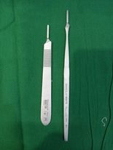

In [33]:
# visualize
# gdrive
#image_path = Path('gdrive/MyDrive/Surgical_instruments/Set_1.v1i.coco/train')
image_path = Path('Surgical_instruments/Sets/Set_2/raw_images')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[0]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [12]:
# using project-specific classes
# 15 classes + background
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)
len(class_map)

16

In [34]:
imgs_array = [PIL.Image.open(file) for file in img_files]

imgs_array = [image.convert('RGB') for image in imgs_array]

img_size = 384 

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)

In [ ]:
# if with interruption in run, may have to upload model

Use previously trained Model.

In [ ]:
from icevision.models import *

checkpoint_path = 'Model_A_ret_mAP34.pth'
checkpoint_and_model = model_from_checkpoint(checkpoint_path)
model = checkpoint_and_model['model'] # Model A
model.eval()

Inference/ generate pseudolabels for Set_2 using Model A.

In [42]:
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)

preds_saved = model_type.predict_from_dl(model, infer_dl,
                                          keep_images=True, detection_threshold = 0.5) 

  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


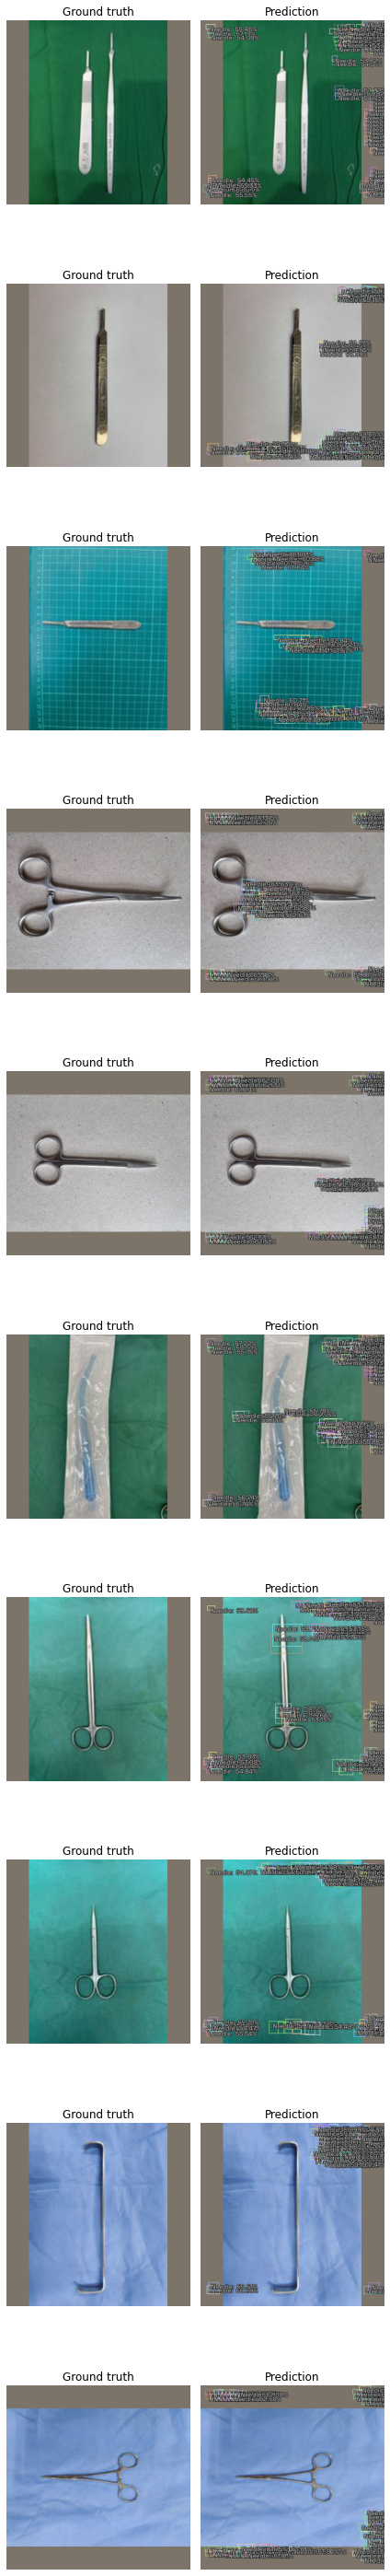

In [43]:
show_preds(preds = preds_saved[0:10])

Poor predictions -> do not use.

Annotate and split dataset in Roboflow.

Use Set_2 UNMERGED for now.

Parse data.

In [49]:
!git clone https://github.com/yrodriguezmd/Surgical_instruments.git

Cloning into 'Surgical_instruments'...
remote: Enumerating objects: 1675, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 1675 (delta 27), reused 7 (delta 7), pack-reused 1484
Receiving objects: 100% (1675/1675), 49.65 MiB | 3.22 MiB/s, done.
Resolving deltas: 100% (246/246), done.


In [50]:
!ls Surgical_instruments/Sets/Set_2/annotated

test  train  valid


In [51]:
path = Path('Surgical_instruments/Sets/Set_2/annotated') # adjust if use git clone vs gdrive

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/_annotations.coco.json',
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',
    img_dir = path/'valid'
)

In [52]:
# dataset already split in annotation tool, maintain grouping

whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

  0%|          | 0/111 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/29 [00:00<?, ?it/s]

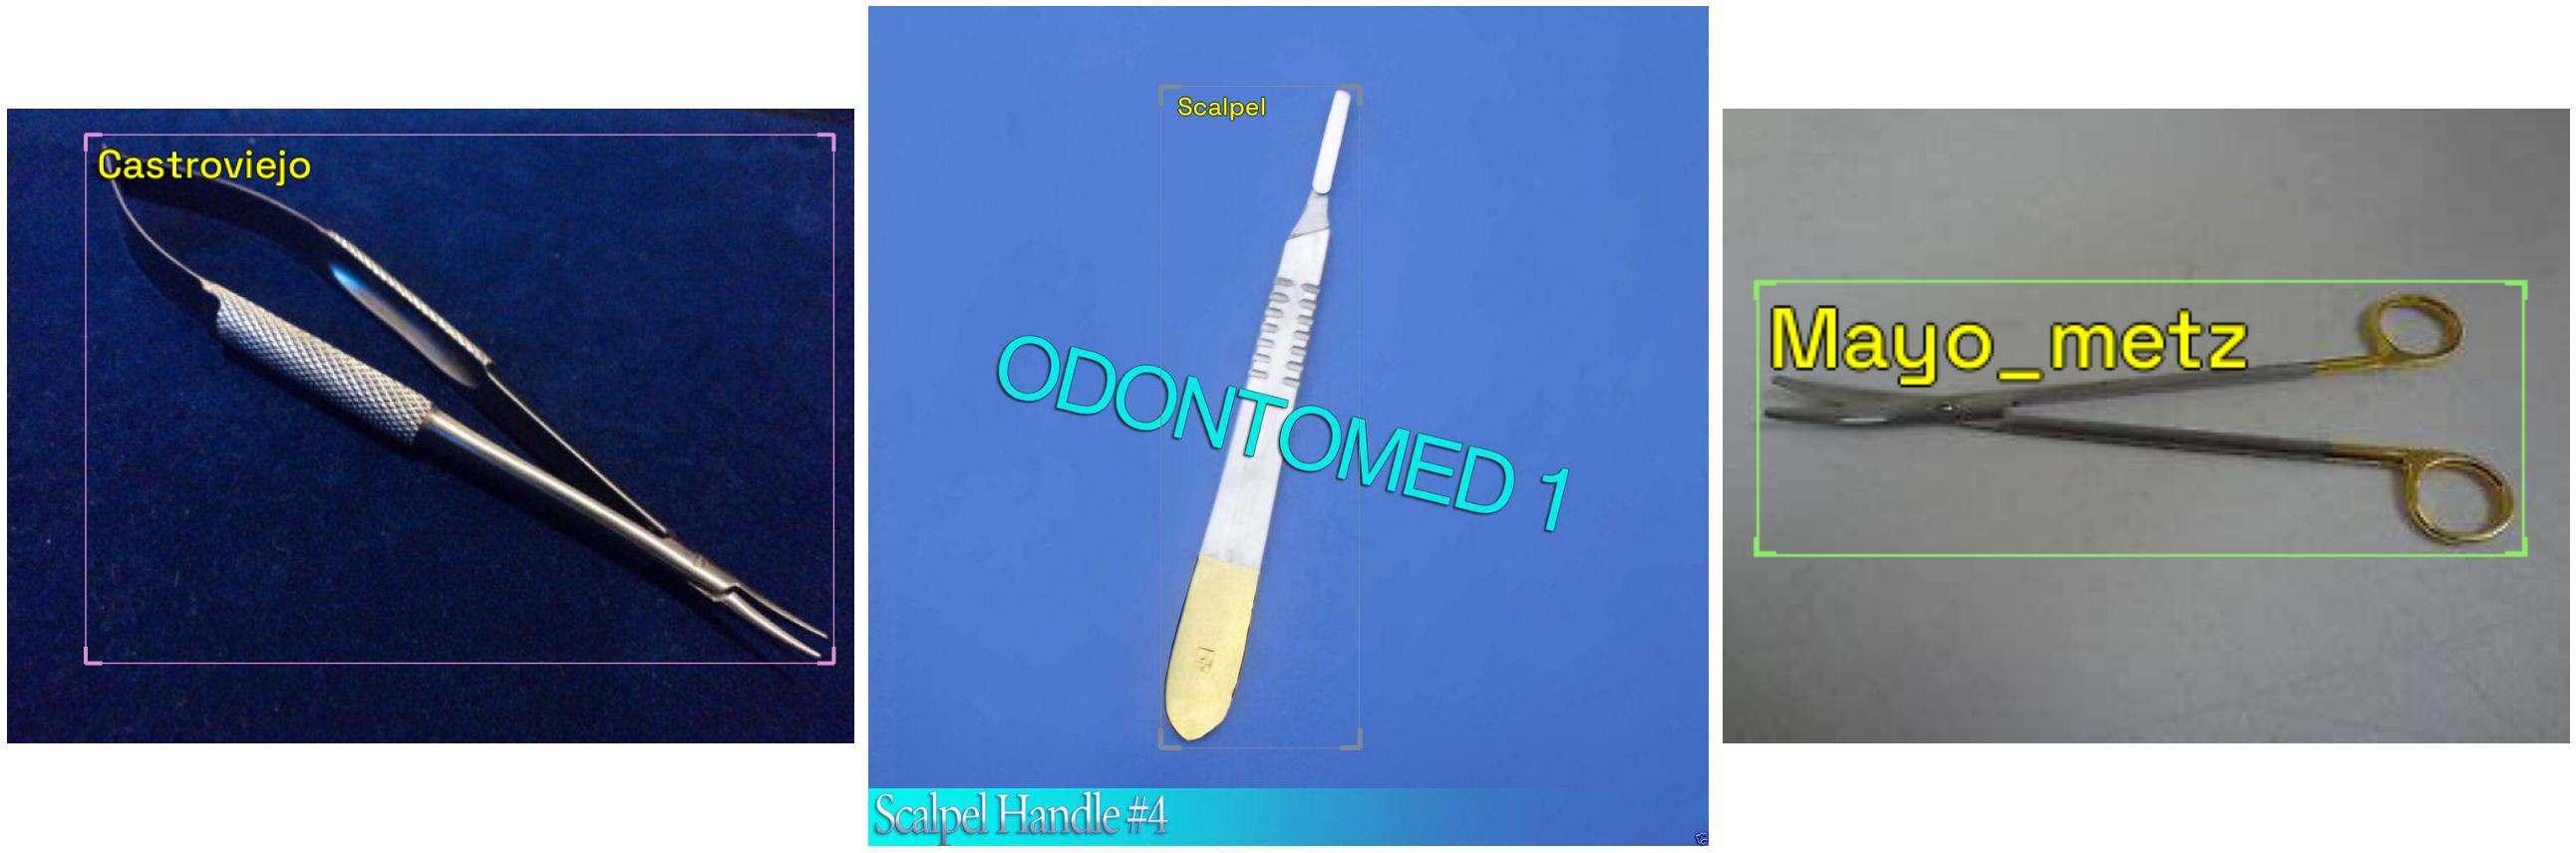

In [53]:
# visualize
show_records(train_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

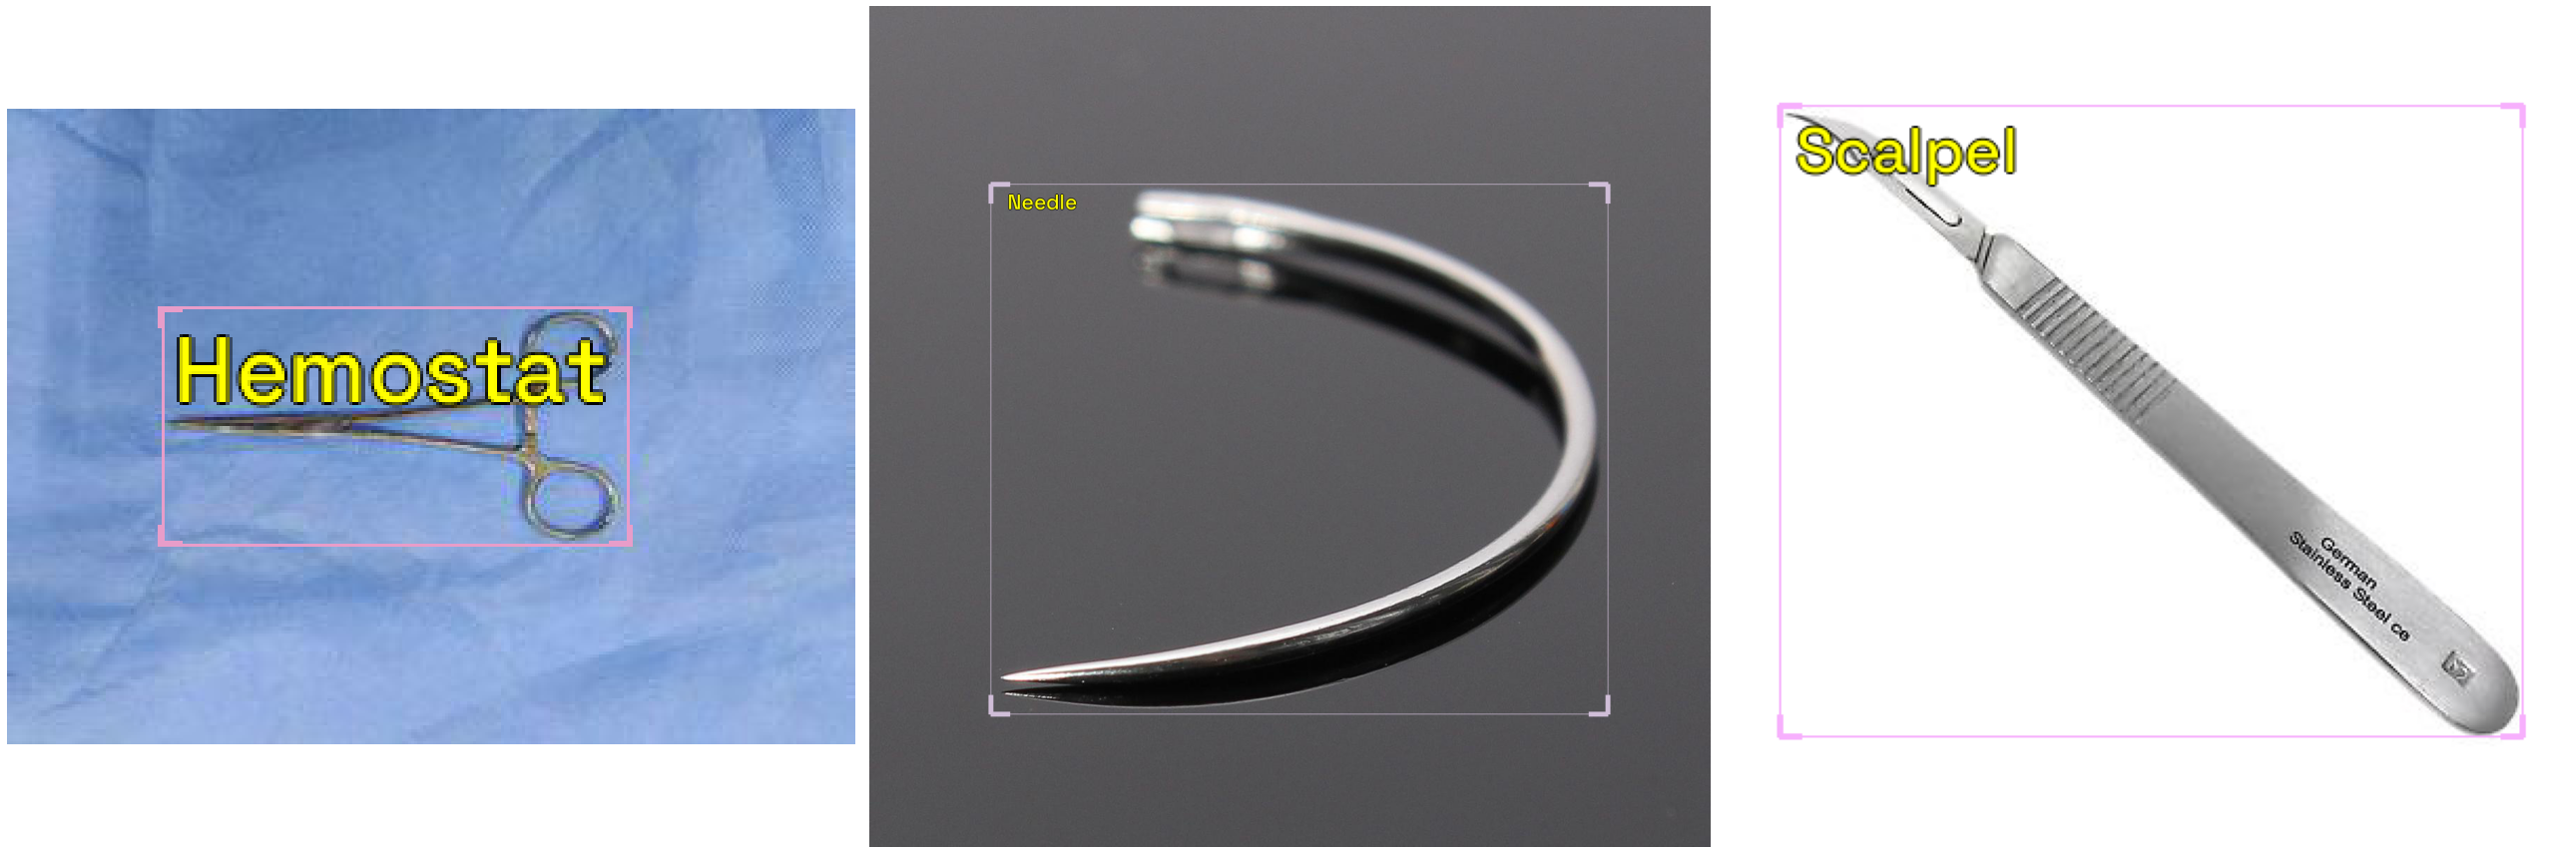

In [54]:
show_records(valid_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

Transforms and Dataset

In [55]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [56]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Train ModelA - RetinaNet to generate teacher Model B. (Using Set_2 UNmerged)

In [71]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

model_type = models.mmdet.retinanet ##
backbone = model_type.backbones.resnet50_fpn_1x ##

#model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(classes),)

In [ ]:
from icevision.models import *

checkpoint_path = 'Model_A_ret_mAP34.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model = checkpoint_and_model['model']
model.train()

In [73]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# use wandbd for training monitoring
from fastai.callback.wandb import *

wandb.init(project = 'Surgical_instruments', name = 'Set_2_unmerged_ModelA-B', reinit = True)

In [74]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,)
                                 # cbs = WandbCallback())

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=5.248074739938602e-05)

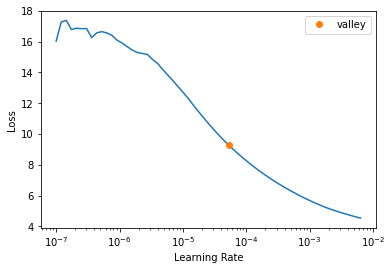

In [69]:
learn.lr_find() 

In [75]:
# using Model A to generate Model B
learn.fine_tune(30, 1e-4)
# without model.train, mAP starts at 0.04
# when rerun from model_type, mAP 0.1

epoch,train_loss,valid_loss,COCOMetric,time
0,1.991270,1.193695,0.101860,00:07


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


epoch,train_loss,valid_loss,COCOMetric,time
0,1.072693,1.138911,0.151053,00:07
1,1.017010,1.097629,0.186468,00:07
2,0.971492,1.031804,0.207878,00:07
3,0.934351,0.975437,0.215019,00:07
4,0.885458,0.934043,0.194123,00:07
5,0.838524,0.893707,0.191563,00:07
6,0.795460,0.835013,0.234094,00:07
7,0.751407,0.803557,0.249193,00:07
8,0.712019,0.800867,0.259607,00:07
9,0.674072,0.747493,0.381645,00:07


In [76]:
import matplotlib.pyplot as plt
def plot_metrics(learn, title):
  plt.plot(L(learn.recorder.values).itemgot())
  plt.xlabel('epoch')
  plt.ylabel('mAP (green), Loss (blue, orange)')
  plt.title(title)
  plt.text(0,-0.2, 
       'Legend: mAP(green), train_loss(blue), valid_loss(orange')
  plt.ylim(0,1);

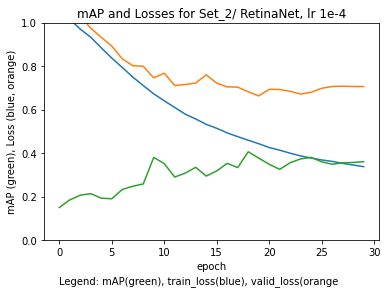

In [77]:
plot_metrics(learn, 'mAP and Losses for Set_2/ RetinaNet, lr 1e-4')

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


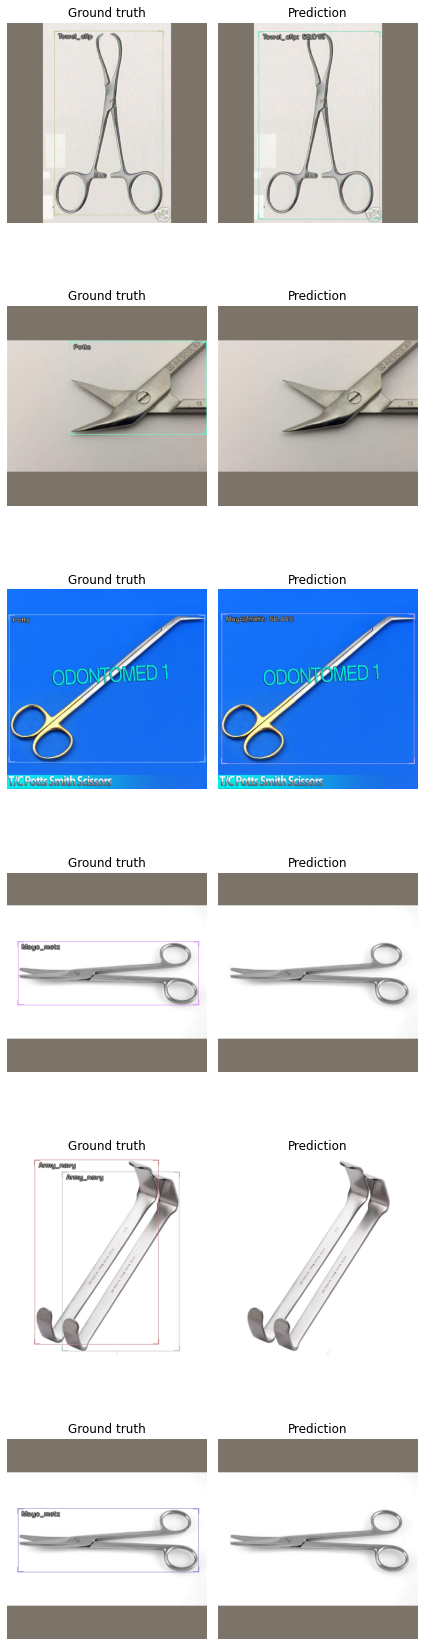

In [78]:
model_type.show_results(model, valid_ds)
# predictions not yet good even with valid ds

Save model as Model B1.

In [79]:
from icevision.models import *

checkpoint_path = 'Model_B1_ret_mAP36.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

In [31]:
# temporary
from google.colab import files
files.download(checkpoint_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Store model for later iteration.

(Too big/ inappropriate file for github)

(Store in GDrive)